This notebook has been inspired by [Q* Learning with FrozenLakev2.ipynb](https://colab.research.google.com/github/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q_Learning_with_FrozenLakev2.ipynb#scrollTo=Xr9nI6dcQM8I) and [Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/unit0/introduction?fw=pt) by Thomas Simonini

# Day 2: Value Function, and Finding the Optimal Policy 

The goal of the agent is to find the optimal policy that maximizes the reward. The value function is used to guide the agent's decision-making process, ultimately leading to the discovery of the optimal policy. In this notebook, we will implement the Q-Learning reinforcement learning algorithm for both 1D and 2D problems.

## Q- Learning 

Q-learning is an algorithm that repeatedly adjusts Q Value to minimize the Bellman error.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \underbrace{\left [ r(s,a) + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \right ]}_{\text{Bellman Error}}$$

The Q-value function at state s and action a, is the expected cumulative reward from taking action a in state s and then following the policy:
$$Q(s,a) = \mathbb{E} \left [ \sum_{t \geq 0} \gamma^t r_t \right ]$$

We learn these Q-values using the Q-learning algorithm.<br>

The discount factor $\gamma$ is the weight for future rewards.<br>


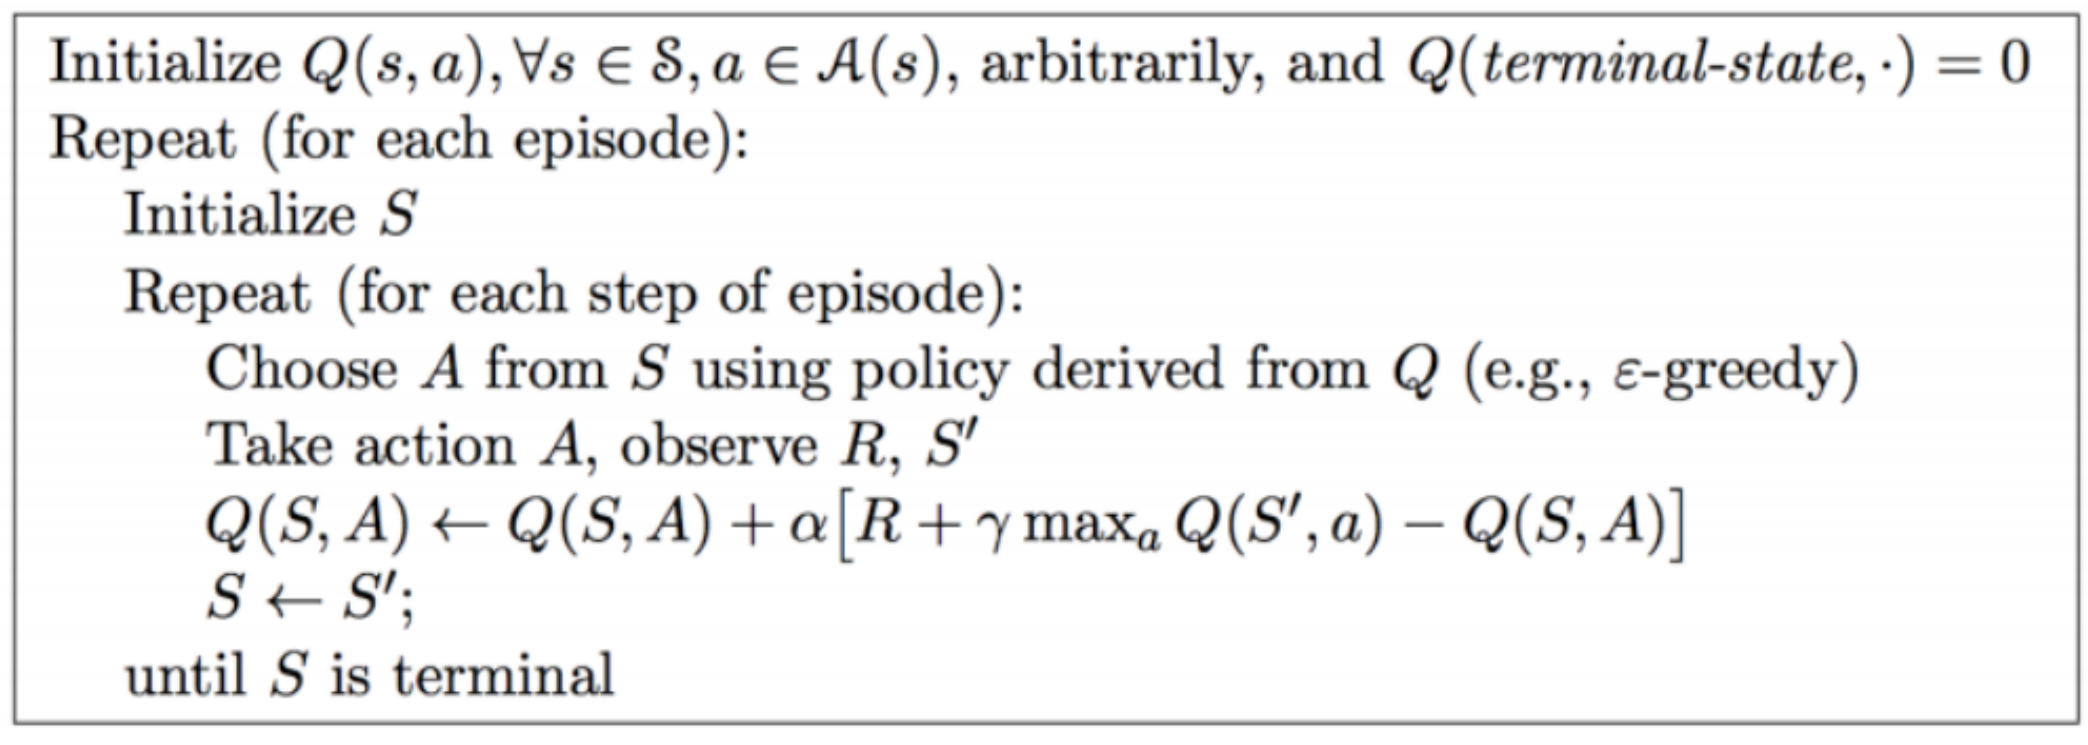

[Image Source](https://uoft-csc413.github.io/2022/)

To read more about Value Function, and finding the optimal policy I suggest the following resources:
[1](http://incompleteideas.net/book/ebook/node34.html)
[2](https://www.mlq.ai/reinforcement-learning-policies-value-functions-bellman-equation/)
[3](https://pub.towardsai.net/the-return-value-functions-bellman-equation-997e0315a272)
[4](https://link.springer.com/book/10.1007/978-1-4842-6809-4)




## Review 

Before starting to implement the Q-learning algorithm, it is important to understand the differences between this lab and the lab on day 1. First, we will initialize the environment and load the necessary libraries.

### Markov Decision Process 
 
To get a quick review of what Markov Decision Process is: [MDP](https://github.com/sudharsan13296/Deep-Reinforcement-Learning-With-Python/blob/master/01.%20Fundamentals%20of%20Reinforcement%20Learning/1.06.%20Markov%20Decision%20Processes.ipynb)


First we start by building the environment, which can be done using Open Ai gym api 

In [189]:
import gym

# Create the CartPole environment (1D)
env_1d = gym.make("CartPole-v1", render_mode="rgb_array")

print("Action Space {}".format(env.action_space))
# Numder of actions, left and right in this case 

print("State Space {}".format(env.observation_space)) 
# this means that the mdp is continus 

Action Space Discrete(2)
State Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


These are helper functions to render and load the environment

In [199]:
import base64, io, os
from IPython.display import HTML
from IPython import display
import os 
from gym.wrappers.monitoring import video_recorder
import glob
import matplotlib.pyplot as plt



os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, env, policy, max_steps=1000):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    for t in range(max_steps):
        vid.capture_frame()
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        #print(f"state: {state}, action: {action}",next_state, reward, done)
        state = next_state

    vid.close()
    env.close()
    

In day 1, we tried the following algorithms to solve the Cart-Pole problem.

In [197]:
import random
# Define the "Always Left" policy
def always_left_policy(observation):
    return 0  # Action: Push cart to the left

# Define the "Always Right" policy
def always_right_policy(observation):
    return 1  # Action: Push cart to the right


# Define the "Random" Policy
def random_policy(observation):
    return random.choice([0, 1])

# Define the "Angle" Policy
def angle_policy(observation):
    angle = observation[2]
    action = 0 if angle < 0 else 1
    return action

# Define the "Radial Velocity" Policy
def pole_vel_policy(observation):
    pole_vel = observation[3]
    action = 0 if pole_vel < 0 else 1
    return action 


We have seen we can evaluate policies by seeing which policy maximize reward, in this part, we will write an error function that is only dependnt on the radial angle to see how each policy of these does in real-time.

In [200]:
def error(env, policy, max_steps=1000):
    error = list()
    state, _ = env.reset()
    for t in range(max_steps):
        angle = state[2]
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        error.append(abs(angle))
    return error

It was observed that simply pushing the cart all the way to the left or right does not help stabilizing the pole.

In [201]:
show_video_of_model("CartPole-v1", env_1d, always_left_policy, max_steps=100)
show_video("CartPole-v1")


Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


In [202]:
show_video_of_model("CartPole-v1", env_1d, always_right_policy,max_steps=100)
show_video("CartPole-v1")


Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


Whereis using a random policy it gave slightly better results. 

In [52]:
show_video_of_model("CartPole-v1", env_1d, random_policy,max_steps=100)
show_video("CartPole-v1")

Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


we can compute the error associated with each policy since the required angle is 0, any deviation from zero is the error such that 

error = abs(angle)

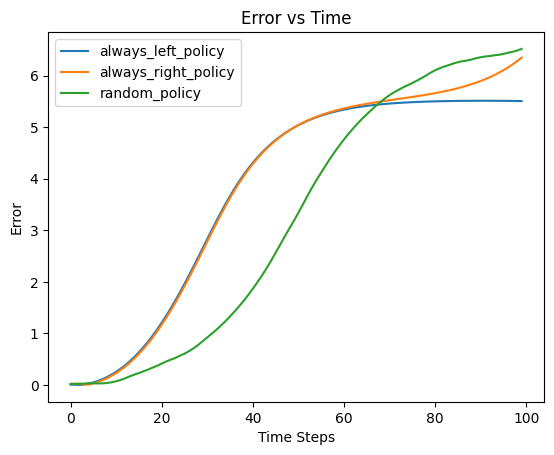

In [80]:
# plotting the error for the three cases above :
case1 = error( env_1d, always_left_policy, max_steps=100)
case2 = error( env_1d, always_right_policy, max_steps=100)
case3 = error( env_1d, random_policy, max_steps=100)
x = range(100)


fig, ax = plt.subplots()
ax.plot(x, case1, label='always_left_policy')
ax.plot(x, case2, label='always_right_policy')
ax.plot(x, case3, label='random_policy')
# Set the legend
ax.legend()

# Set the x and y axis labels
ax.set_xlabel('Time Steps')
ax.set_ylabel('Error')

# Set the title
ax.set_title('Error vs Time')

# Display the plot
plt.show()

It can be seen that the error accumalte with time, so with further playing we were able to figure out policies that are more stable with time by controlling the cart based on the angle of the pole, or the pole radial velocity. 

In [203]:
show_video_of_model("CartPole-v1", env_1d, angle_policy,max_steps=250)
show_video("CartPole-v1")

Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


In [204]:
show_video_of_model("CartPole-v1", env_1d, pole_vel_policy,max_steps=250)
show_video("CartPole-v1")


Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


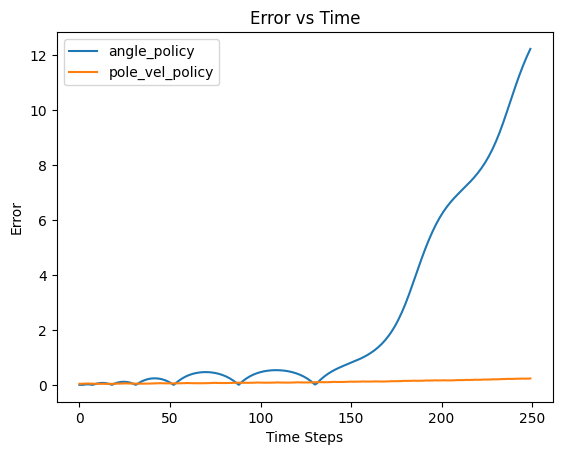

In [205]:
# plotting the error for the three cases above :
case4 = error( env_1d, angle_policy, max_steps=250)
case5 = error( env_1d, pole_vel_policy, max_steps=250)
x = range(250)


fig, ax = plt.subplots()
ax.plot(x, case4, label='angle_policy')
ax.plot(x, case5, label='pole_vel_policy')
# Set the legend
ax.legend()

# Set the x and y axis labels
ax.set_xlabel('Time Steps')
ax.set_ylabel('Error')

# Set the title
ax.set_title('Error vs Time')

# Display the plot
plt.show()

We can observe that we have reached the optimal policy. However, this optimal policy was not attained using machine learning. We relied on physics to model the problem and employed a control strategy to stabilize it. Nonetheless, our goal is for the model to autonomously stabilize the pole and determine the best policy. This is where Q-learning comes into play.

# Day 2: Part 1 Solving in 1d 

As the cart-pole problem is a continuous Markov Decision Process (MDP), it is necessary to quantize it in order to solve it. 
The  following part was taken from [Github](https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1/blob/master/cartpole.ipynb)


In [219]:
import math
from typing import Tuple
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer


n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer(angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))


### Q-Table
Now, we need to create Q-table. A Q table helps us find the best action for each state. It gives us the Q-value for each state-action pair.<br>

To know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size. OpenAI Gym provides us a way to do that.

In [227]:
qtable = np.zeros(n_bins + (env.action_space.n,))
qtable.shape

(6, 12, 2)

 ### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [256]:
# Here, we will specify the hyperparameters

total_episodes = 300       # Total training episodes
learning_rate = 0.1          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

### Training

In [257]:
# List of rewards
rewards = []

for episode in range(total_episodes):
    # Reset the environment
    
       

    
    state = env_1d.reset()[0]
    angle = state_cont[2]
    vel = state_cont[3] 
    state, done = discretizer(angle,vel), False
    
    
    
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state])

        # Else doing a random choice --> exploration
        else:
            action = env_1d.action_space.sample()


        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env_1d.step(action)
        angle = new_state[2]
        vel = new_state[3] 
        new_state = discretizer(angle,vel)
        done = terminated or truncated

        # Update Q(s,a):= Q(s,a) + lr * [R(s,a) + gamma * max Q(s',a') * (1-done) - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state][action] = qtable[state][action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) * (1-done) -  qtable[state][action] )

        total_rewards += reward

        # Our new state is state
        state = new_state

        # If done (if we're dead) : finish episode
        if done == True:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")


Episode 0: Reward = 11.0, Epsilon = 1.0
Episode 1: Reward = 30.0, Epsilon = 0.9995051237293776
Episode 2: Reward = 19.0, Epsilon = 0.9990104948350412
Episode 3: Reward = 18.0, Epsilon = 0.9985161131933338
Episode 4: Reward = 18.0, Epsilon = 0.9980219786806598
Episode 5: Reward = 10.0, Epsilon = 0.9975280911734855
Episode 6: Reward = 19.0, Epsilon = 0.9970344505483393
Episode 7: Reward = 9.0, Epsilon = 0.9965410566818107
Episode 8: Reward = 66.0, Epsilon = 0.9960479094505515
Episode 9: Reward = 13.0, Epsilon = 0.9955550087312749
Episode 10: Reward = 37.0, Epsilon = 0.9950623544007555
Episode 11: Reward = 20.0, Epsilon = 0.9945699463358298
Episode 12: Reward = 11.0, Epsilon = 0.9940777844133959
Episode 13: Reward = 14.0, Epsilon = 0.9935858685104132
Episode 14: Reward = 20.0, Epsilon = 0.9930941985039028
Episode 15: Reward = 26.0, Epsilon = 0.992602774270947
Episode 16: Reward = 22.0, Epsilon = 0.99211159568869
Episode 17: Reward = 11.0, Epsilon = 0.991620662634337
Episode 18: Reward = 3

In [275]:
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 26.166666666666668
[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 9.83224203  6.2313048 ]
  [15.40224573  7.31965652]
  [17.75670142  7.83694137]
  [17.25183102 11.86733383]
  [19.8723186  17.56507121]
  [19.93696108 17.32960676]
  [19.94043409 18.7582778 ]
  [19.93766038 19.6863415 ]
  [18.9447442  19.93595617]
  [18.34329933 19.9320412 ]
  [ 6.27867775 19.44031725]
  [13.12343771 11.92231006]]

 [[18.20943817 15.26089905]
  [19.95435936 16.77984654]
  [19.99901119 15.93763927]
  [19.98778727 19.51880398]
  [19.99964187 19.9659842 ]
  [19.99996967 19.99973255]
  [19.99998305 19.99973996]
  [19.98984468 19.99995513]
  [19.99998874 19.99999261]
  [19.29891756 19.99998848]
  [18.92

### Visualization

In [274]:
vid = video_recorder.VideoRecorder(env_1d, path="video/{}.mp4".format("CartPole-v1"))

# Reset the environment
state = env_1d.reset()[0]
angle = state[2]
vel = state[3] 
state, done = discretizer(angle,vel), False



max_steps = 250
for t in range(max_steps):
    vid.capture_frame()  
    
    action = np.argmax(qtable[state])
    next_state, reward, terminated, truncated, info = env_1d.step(action)
    angle = next_state[2]
    vel = next_state[3] 
    state = discretizer(angle,vel)

vid.close()
env.close()

show_video("CartPole-v1")


Moviepy - Building video video/CartPole-v1.mp4.
Moviepy - Writing video video/CartPole-v1.mp4



Moviepy - Done !
Moviepy - video ready video/CartPole-v1.mp4


This is the results of training it for low number of episodes! adjust the parameters, try removing the greedy function and see how it effect the performance. 

# Day 2: Part 2 Solving in 2d 

Frozen lake is a toy text environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. <br>

We can also set the lake to be slippery so that the agent does not always move in the intended direction. here, we will only look at the non-slippery case. But you are welcome to try the slippery one.<br>

You can read more about the environment [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

![Frozen Lake](https://gymnasium.farama.org/_images/frozen_lake.gif)


First we start by building the environment, which can be done using Open Ai gym api 

In [158]:
env_2d = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")


In [159]:
state_size = env_2d.observation_space.n
action_size = env_2d.action_space.n

state_size, action_size

(16, 4)

In [160]:
# Create our Q table with state_size rows and action_size columns (64x4). We can set all values to zero for now.
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [121]:
# Here, we will specify the hyperparameters

total_episodes = 20000       # Total training episodes
learning_rate = 0.1          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

### Training

In [177]:
# List of rewards
rewards = []

for episode in range(total_episodes):
    # Reset the environment
    state = env_2d.reset()[0]
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env_2d.action_space.sample()


        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env_2d.step(action)
        done = terminated or truncated

        # Update Q(s,a):= Q(s,a) + lr * [R(s,a) + gamma * max Q(s',a') * (1-done) - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) * (1-done) - qtable[state, action])

        total_rewards += reward

        # Our new state is state
        state = new_state

        # If done (if we're dead) : finish episode
        if done == True:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")



Episode 0: Reward = 1.0, Epsilon = 1.0
Episode 1: Reward = 0.0, Epsilon = 0.9995051237293776
Episode 2: Reward = 0.0, Epsilon = 0.9990104948350412
Episode 3: Reward = 0.0, Epsilon = 0.9985161131933338
Episode 4: Reward = 0.0, Epsilon = 0.9980219786806598
Episode 5: Reward = 0.0, Epsilon = 0.9975280911734855
Episode 6: Reward = 0.0, Epsilon = 0.9970344505483393
Episode 7: Reward = 0.0, Epsilon = 0.9965410566818107
Episode 8: Reward = 0.0, Epsilon = 0.9960479094505515
Episode 9: Reward = 0.0, Epsilon = 0.9955550087312749
Episode 10: Reward = 0.0, Epsilon = 0.9950623544007555
Episode 11: Reward = 0.0, Epsilon = 0.9945699463358298
Episode 12: Reward = 0.0, Epsilon = 0.9940777844133959
Episode 13: Reward = 0.0, Epsilon = 0.9935858685104132
Episode 14: Reward = 0.0, Epsilon = 0.9930941985039028
Episode 15: Reward = 0.0, Epsilon = 0.992602774270947
Episode 16: Reward = 0.0, Epsilon = 0.99211159568869
Episode 17: Reward = 0.0, Epsilon = 0.991620662634337
Episode 18: Reward = 0.0, Epsilon = 0.9

In [280]:

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 26.166666666666668
[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 9.83224203  6.2313048 ]
  [15.40224573  7.31965652]
  [17.75670142  7.83694137]
  [17.25183102 11.86733383]
  [19.8723186  17.56507121]
  [19.93696108 17.32960676]
  [19.94043409 18.7582778 ]
  [19.93766038 19.6863415 ]
  [18.9447442  19.93595617]
  [18.34329933 19.9320412 ]
  [ 6.27867775 19.44031725]
  [13.12343771 11.92231006]]

 [[18.20943817 15.26089905]
  [19.95435936 16.77984654]
  [19.99901119 15.93763927]
  [19.98778727 19.51880398]
  [19.99964187 19.9659842 ]
  [19.99996967 19.99973255]
  [19.99998305 19.99973996]
  [19.98984468 19.99995513]
  [19.99998874 19.99999261]
  [19.29891756 19.99998848]
  [18.92

### Visualization

In [188]:
vid = video_recorder.VideoRecorder(env_2d, path="video/{}.mp4".format("FrozenLake-v1"))

# Reset the environment
state = env_2d.reset()[0]

max_steps = 12
for t in range(max_steps):
    vid.capture_frame()  
    
    action = np.argmax(qtable[state])
    next_state, reward, terminated, truncated, info = env_2d.step(action)
    state = next_state

vid.close()
env.close()

show_video("FrozenLake-v1")


Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
